# Clustering for Semi-Supervised Learning

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

## Load the data

In [2]:
X_digits, y_digits = load_digits(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

## Train the model on only a subset of available data

Let's assume we only have a subset of labeled data available, e.g. 50 instances with which we train our model.

In [4]:
n_labeled = 50
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

In [5]:
log_reg.score(X_test, y_test)

0.8511111111111112

As expected, the performs is not so great since we only trained on 50 instances.

## Cluster the images

We cluster the images in 50 clusters and get the most representative digits for each cluster.

In [6]:
k = 50
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

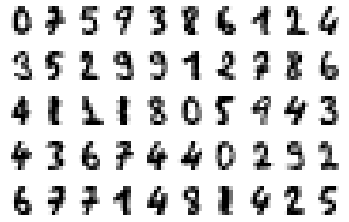

In [7]:
fig, axs = plt.subplots(5, 10)

for row in range(5):
    for col in range(10):
        currPic = row*10 + col
        axs[row,col].imshow(1. - X_representative_digits[currPic].reshape(8,8)/255., cmap='gray')
        axs[row,col].axis('off')

plt.show()

## "Manually" label the subset of data

We could now manually add labels for the data shown above; for reproducability of the code, we just take over the values of the labels from the data.

In [18]:
y_representative_digits = y_train[representative_digit_idx]
y_representative_digits

array([0, 7, 5, 9, 3, 8, 6, 1, 2, 4, 3, 5, 2, 9, 9, 1, 2, 7, 8, 6, 4, 1,
       1, 1, 8, 0, 5, 9, 4, 3, 4, 3, 6, 7, 4, 4, 0, 2, 9, 2, 6, 7, 7, 1,
       4, 8, 1, 4, 2, 5])

## Train the model on the manually labeled data

We now train the model on the manually labeled data. The chosen training instances are representative of the cluster centers, so we expect the model to perform better now.

In [19]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9066666666666666

As expected, the performance increased significantly despite still having trained on only 50 instances.

## Increasing the performance with label propagation

We now additionally propagate the labels of the representative instances to the other unlabeled data of the same cluster. First, we do this for all the data in the cluster (even to outliers and data close to the clusters' borders).

In [20]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [21]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9088888888888889

The score slightly improved as compared to the model being trained without label propagation.

## Further increasing the performance with partial label propagation

We again perform label propagation, but this time, we restrict the propagation to a certain percentile close to the centroid.

In [22]:
percentile_closest = 20

Get the cluster distance for each instance (i.e. the distance to the centroid for each instance and its assigned cluster)

In [23]:
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

Filter out all instances that are not within the given percentile and propagate the labels only to those that are.

In [24]:
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1
    
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [25]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9066666666666666